![](https://ai-studio-static-online.cdn.bcebos.com/61c6f63d666f4a81b98171b775ee8d486e610cf8fa654225b5cdd3c4b7db96ce)本项目对应视频课程已上线，点击前往学习[深度学习CV从入门到实战](https://aistudio.baidu.com/aistudio/course/introduce/789)-课节9猫狗视频实战讲解


图像分类是根据图像的语义信息将不同类别图像区分开来，是计算机视觉中重要的基本问题

猫狗分类属于图像分类中的粗粒度分类问题

![](https://ai-studio-static-online.cdn.bcebos.com/1cd9ef37036647c2afbbc866a7d2c14179f33cf1e2494d1f8f00de556d231452)

实践总体过程和步骤如下图

![](https://ai-studio-static-online.cdn.bcebos.com/b008c158886547649a9b06f6ae96df44447427fe65db4bac82b609334bd0d25c)


**首先导入必要的包**

paddle.fluid--->PaddlePaddle深度学习框架

os------------->python的模块，可使用该模块对操作系统进行操作

In [1]:
#导入需要的包
import paddle as paddle
import paddle.fluid as fluid
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os

# **Step1:准备数据**
**（1）数据集介绍**

我们使用CIFAR10数据集。CIFAR10数据集包含60,000张32x32的彩色图片，10个类别，每个类包含6,000张。其中50,000张图片作为训练集，10000张作为验证集。这次我们只对其中的猫和狗两类进行预测。

![](https://ai-studio-static-online.cdn.bcebos.com/567016c028714d21bfe690dee70e9ea31512ba3575bd4d7caebbb7ade05c72ac)

**(2)train_reader和test_reader**

paddle.dataset.cifar.train10()和test10()分别获取cifar训练集和测试集

paddle.reader.shuffle()表示每次缓存BUF_SIZE个数据项，并进行打乱

paddle.batch()表示每BATCH_SIZE组成一个batch

**（3）数据集下载**

由于本次实践的数据集稍微比较大，以防出现不好下载的问题，为了提高效率，可以用下面的代码进行数据集的下载。
```

!mkdir -p /home/aistudio/.cache/paddle/dataset/cifar/

!wget "http://ai-atest.bj.bcebos.com/cifar-10-python.tar.gz" -O cifar-10-python.tar.gz

!mv cifar-10-python.tar.gz /home/aistudio/.cache/paddle/dataset/cifar/
```

In [2]:
!mkdir -p  /home/aistudio/.cache/paddle/dataset/cifar/
!wget "http://ai-atest.bj.bcebos.com/cifar-10-python.tar.gz" -O cifar-10-python.tar.gz
!mv cifar-10-python.tar.gz  /home/aistudio/.cache/paddle/dataset/cifar/
!ls -a /home/aistudio/.cache/paddle/dataset/cifar/

--2020-10-24 09:51:48--  http://ai-atest.bj.bcebos.com/cifar-10-python.tar.gz
Resolving ai-atest.bj.bcebos.com (ai-atest.bj.bcebos.com)... 182.61.200.229, 182.61.200.195, 2409:8c00:6c21:10ad:0:ff:b00e:67d
Connecting to ai-atest.bj.bcebos.com (ai-atest.bj.bcebos.com)|182.61.200.229|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  18.6MB/s    in 8.3s    

2020-10-24 09:51:56 (19.6 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

.  ..  cifar-10-python.tar.gz


In [3]:
BATCH_SIZE = 64
#用于训练的数据提供器
train_reader = paddle.batch(
    paddle.reader.shuffle(paddle.dataset.cifar.train10(), 
                          buf_size=128*100),           
    batch_size=BATCH_SIZE)                                
#用于测试的数据提供器
test_reader = paddle.batch(
    paddle.dataset.cifar.test10(),                            
    batch_size=BATCH_SIZE)                                

# **Step2.网络配置**

**（1）网络搭建**

*** **CNN网络模型**

在CNN模型中，卷积神经网络能够更好的利用图像的结构信息。下面定义了一个较简单的卷积神经网络。显示了其结构：输入的二维图像，先经过三次卷积层、池化层和Batchnorm，再经过全连接层，最后使用softmax分类作为输出层。

![](https://ai-studio-static-online.cdn.bcebos.com/98b9b702cce040fb8a874e28eae6d34ace6025a2c9444cdd954ab5f14d69cfdc)

**池化**是非线性下采样的一种形式，主要作用是通过减少网络的参数来减小计算量，并且能够在一定程度上控制过拟合。通常在卷积层的后面会加上一个池化层。paddlepaddle池化默认为最大池化。是用不重叠的矩形框将输入层分成不同的区域，对于每个矩形框的数取最大值作为输出

**Batchnorm**顾名思义是对每batch个数据同时做一个norm。作用就是在深度神经网络训练过程中使得每一层神经网络的输入保持相同分布的。



In [4]:
def convolutional_neural_network(img):
    # 第一个卷积-池化层
    conv_pool_1 = fluid.nets.simple_img_conv_pool(
        input=img,         # 输入图像
        filter_size=3,     # 滤波器的大小
        num_filters=256,    # filter 的数量。它与输出的通道相同
        pool_size=2,       # 池化核大小2*2
        pool_stride=2,     # 池化步长
        act="relu")        # 激活类型
    conv_pool_1 = fluid.layers.dropout(conv_pool_1, dropout_prob=0.5) #加入dropout
    conv_pool_1 = fluid.layers.batch_norm(conv_pool_1)
    # 第二个卷积-池化层
    conv_pool_2 = fluid.nets.simple_img_conv_pool(
        input=conv_pool_1,
        filter_size=5,
        num_filters=512,
        pool_size=2,
        pool_stride=2,
        act="relu")
    conv_pool_2 = fluid.layers.dropout(conv_pool_2, dropout_prob=0.6) #MMXXX加入dropout
    conv_pool_2 = fluid.layers.batch_norm(conv_pool_2)
    # 第三个卷积-池化层
    conv_pool_3 = fluid.nets.simple_img_conv_pool(
        input=conv_pool_2,
        filter_size=5,
        num_filters=256,
        pool_size=2,
        pool_stride=2,
        act="relu")
    conv_pool_3 = fluid.layers.dropout(conv_pool_3, dropout_prob=0.7) #MMXXX加入dropout
    conv_pool_3 = fluid.layers.batch_norm(conv_pool_3)
    # 以softmax为激活函数的全连接输出层，10类数据输出10个数字
    fc1 = fluid.layers.fc(input=conv_pool_3, size=128, act='relu')
    fc2 = fluid.layers.fc(input=fc1, size=100, act='relu')
    fc3 = fluid.layers.fc(input=fc2, size=100, act='relu')
    prediction = fluid.layers.fc(input=fc2, size=10, act='softmax')
    return prediction

**（2）定义数据**

In [5]:
#定义输入数据
data_shape = [3, 32, 32]
images = fluid.layers.data(name='images', shape=data_shape, dtype='float32')
label = fluid.layers.data(name='label', shape=[1], dtype='int64')

**（3）获取分类器**

下面cell里面使用了CNN方式进行分类

In [6]:
# 获取分类器，用cnn进行分类
predict =  convolutional_neural_network(images)

**（4）定义损失函数和准确率**

这次使用的是交叉熵损失函数，该函数在分类任务上比较常用。

定义了一个损失函数之后，还有对它求平均值，因为定义的是一个Batch的损失值。

同时我们还可以定义一个准确率函数，这个可以在我们训练的时候输出分类的准确率。

In [7]:
# 获取损失函数和准确率
cost = fluid.layers.cross_entropy(input=predict, label=label) # 交叉熵
avg_cost = fluid.layers.mean(cost)                            # 计算cost中所有元素的平均值
acc = fluid.layers.accuracy(input=predict, label=label)       #使用输入和标签计算准确率

**（5）定义优化方法**

这次我们使用的是Adam优化方法，同时指定学习率为0.001

In [8]:
# 获取测试程序
test_program = fluid.default_main_program().clone(for_test=True)

# 定义优化方法
optimizer =fluid.optimizer.Adam(learning_rate=2e-4)
optimizer.minimize(avg_cost)
print("完成")

完成


在上述模型配置完毕后，得到两个fluid.Program：fluid.default_startup_program() 与fluid.default_main_program() 配置完毕了。

参数初始化操作会被写入fluid.default_startup_program()

fluid.default_main_program()用于获取默认或全局main program(主程序)。该主程序用于训练和测试模型。fluid.layers 中的所有layer函数可以向 default_main_program 中添加算子和变量。default_main_program 是fluid的许多编程接口（API）的Program参数的缺省值。例如,当用户program没有传入的时候， Executor.run() 会默认执行 default_main_program 。

# **Step3.模型训练 and Step4.模型评估**

**（1）创建Executor**

首先定义运算场所 fluid.CPUPlace()和 fluid.CUDAPlace(0)分别表示运算场所为CPU和GPU

Executor:接收传入的program，通过run()方法运行program。

In [ ]:
# 定义使用CPU还是GPU，使用CPU时use_cuda = False,使用GPU时use_cuda = True
use_cuda = True
place = fluid.CUDAPlace(0) if use_cuda else fluid.CPUPlace()


In [ ]:
# 创建执行器，初始化参数

exe = fluid.Executor(place)
exe.run(fluid.default_startup_program())

[]

**(2)定义数据映射器**

DataFeeder 负责将reader(读取器)返回的数据转成一种特殊的数据结构，使它们可以输入到 Executor
 


In [ ]:

feeder = fluid.DataFeeder( feed_list=[images, label],place=place)

**（3）定义绘制训练过程的损失值和准确率变化趋势的方法draw_train_process**

In [ ]:
all_train_iter=0
all_train_iters=[]
all_train_costs=[]
all_train_accs=[]

def draw_train_process(title,iters,costs,accs,label_cost,lable_acc):
    plt.title(title, fontsize=24)
    plt.xlabel("iter", fontsize=20)
    plt.ylabel("cost/acc", fontsize=20)
    plt.plot(iters, costs,color='red',label=label_cost) 
    plt.plot(iters, accs,color='green',label=lable_acc) 
    plt.legend()
    plt.grid()
    plt.show()

**（3）训练并保存模型**

Executor接收传入的program,并根据feed map(输入映射表)和fetch_list(结果获取表) 向program中添加feed operators(数据输入算子)和fetch operators（结果获取算子)。 feed map为该program提供输入数据。fetch_list提供program训练结束后用户预期的变量。

每一个Pass训练结束之后，再使用验证集进行验证，并打印出相应的损失值cost和准确率acc。

Pass:0, Batch:0, Cost:2.54123, Accuracy:0.09375
Pass:0, Batch:100, Cost:2.16230, Accuracy:0.23438
Pass:0, Batch:200, Cost:1.91803, Accuracy:0.25000
Pass:0, Batch:300, Cost:1.75548, Accuracy:0.42188
Pass:0, Batch:400, Cost:1.78840, Accuracy:0.32812
Pass:0, Batch:500, Cost:1.73667, Accuracy:0.31250
Pass:0, Batch:600, Cost:1.83235, Accuracy:0.29688
Pass:0, Batch:700, Cost:1.76952, Accuracy:0.39062
Test:0, Cost:1.54033, ACC:0.43650
Pass:1, Batch:0, Cost:1.61906, Accuracy:0.42188
Pass:1, Batch:100, Cost:1.64907, Accuracy:0.45312
Pass:1, Batch:200, Cost:1.66453, Accuracy:0.42188
Pass:1, Batch:300, Cost:1.39147, Accuracy:0.50000
Pass:1, Batch:400, Cost:1.51004, Accuracy:0.45312
Pass:1, Batch:500, Cost:1.31009, Accuracy:0.54688
Pass:1, Batch:600, Cost:1.44099, Accuracy:0.45312
Pass:1, Batch:700, Cost:1.56671, Accuracy:0.39062
Test:1, Cost:1.38396, ACC:0.49781
Pass:2, Batch:0, Cost:1.50322, Accuracy:0.50000
Pass:2, Batch:100, Cost:1.36776, Accuracy:0.56250
Pass:2, Batch:200, Cost:1.46158, Accur

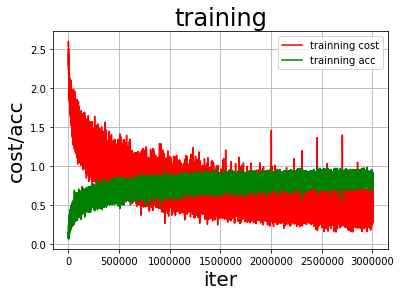

In [ ]:
EPOCH_NUM = 60
model_save_dir = "/home/aistudio/work/catdog.inference.model"

for pass_id in range(EPOCH_NUM):
    # 开始训练
    for batch_id, data in enumerate(train_reader()):                        #遍历train_reader的迭代器，并为数据加上索引batch_id
        train_cost,train_acc = exe.run(program=fluid.default_main_program(),#运行主程序
                             feed=feeder.feed(data),                        #喂入一个batch的数据
                             fetch_list=[avg_cost, acc])                    #fetch均方误差和准确率

        
        all_train_iter=all_train_iter+BATCH_SIZE
        all_train_iters.append(all_train_iter)
        all_train_costs.append(train_cost[0])
        all_train_accs.append(train_acc[0])
        
        #每100次batch打印一次训练、进行一次测试
        if batch_id % 100 == 0:                                             
            print('Pass:%d, Batch:%d, Cost:%0.5f, Accuracy:%0.5f' % 
            (pass_id, batch_id, train_cost[0], train_acc[0]))
            

    # 开始测试
    test_costs = []                                                         #测试的损失值
    test_accs = []                                                          #测试的准确率
    for batch_id, data in enumerate(test_reader()):
        test_cost, test_acc = exe.run(program=test_program,                 #执行测试程序
                                      feed=feeder.feed(data),               #喂入数据
                                      fetch_list=[avg_cost, acc])           #fetch 误差、准确率
        test_costs.append(test_cost[0])                                     #记录每个batch的误差
        test_accs.append(test_acc[0])                                       #记录每个batch的准确率
    
    # 求测试结果的平均值
    test_cost = (sum(test_costs) / len(test_costs))                         #计算误差平均值（误差和/误差的个数）
    test_acc = (sum(test_accs) / len(test_accs))                            #计算准确率平均值（ 准确率的和/准确率的个数）
    print('Test:%d, Cost:%0.5f, ACC:%0.5f' % (pass_id, test_cost, test_acc))
    
#保存模型
# 如果保存路径不存在就创建
if not os.path.exists(model_save_dir):
    os.makedirs(model_save_dir)
print ('save models to %s' % (model_save_dir))
fluid.io.save_inference_model(model_save_dir,
                              ['images'],
                              [predict],
                              exe)
print('训练模型保存完成！')
draw_train_process("training",all_train_iters,all_train_costs,all_train_accs,"trainning cost","trainning acc")


# **Step5.模型预测**

**（1）创建预测用的Executor**

In [17]:
infer_exe = fluid.Executor(place)
inference_scope = fluid.core.Scope() 

**(2)图片预处理**

在预测之前，要对图像进行预处理。

首先将图片大小调整为32*32，接着将图像转换成一维向量，最后再对一维向量进行归一化处理。

In [18]:
def load_image(file):
        #打开图片
        im = Image.open(file)
        #将图片调整为跟训练数据一样的大小  32*32，                   设定ANTIALIAS，即抗锯齿.resize是缩放
        im = im.resize((32, 32), Image.ANTIALIAS)
        #建立图片矩阵 类型为float32
        im = np.array(im).astype(np.float32)
        #矩阵转置 
        im = im.transpose((2, 0, 1))                               
        #将像素值从【0-255】转换为【0-1】
        im = im / 255.0
        #print(im)       
        im = np.expand_dims(im, axis=0)
        # 保持和之前输入image维度一致
        print('im_shape的维度：',im.shape)
        return im

**(3)开始预测**

通过fluid.io.load_inference_model，预测器会从params_dirname中读取已经训练好的模型，来对从未遇见过的数据进行预测。

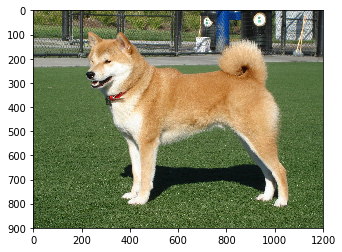

im_shape的维度： (1, 3, 32, 32)
results [array([[2.30493475e-04, 4.01558791e-05, 1.36894975e-02, 1.42493676e-02,
        8.15201104e-02, 7.92817295e-01, 8.59158245e-05, 9.72925052e-02,
        2.60221004e-05, 4.86637437e-05]], dtype=float32)]
infer results: dog


In [27]:
model_save_dir = "/home/aistudio/work/catdog.inference.model"
with fluid.scope_guard(inference_scope):
    #从指定目录中加载 推理model(inference model)
    [inference_program, # 预测用的program
     feed_target_names, # 是一个str列表，它包含需要在推理 Program 中提供数据的变量的名称。 
     fetch_targets] = fluid.io.load_inference_model(model_save_dir,#fetch_targets：是一个 Variable 列表，从中我们可以得到推断结果。
                                                    infer_exe)     #infer_exe: 运行 inference model的 executor
    
    infer_path='dog1.jpg'
    img = Image.open(infer_path)
    plt.imshow(img)   
    plt.show()    
    
    img = load_image(infer_path)

    results = infer_exe.run(inference_program,                 #运行预测程序
                            feed={feed_target_names[0]: img},  #喂入要预测的img
                            fetch_list=fetch_targets)          #得到推测结果
    print('results',results)
    label_list = [
        "airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse",
        "ship", "truck"
        ]
    print("infer results: %s" % label_list[np.argmax(results[0])])